In [1]:
%load_ext autoreload
%autoreload 2

from multicamera_acquisition.acquisition import refactor_acquire_video, AcquisitionLoop
from multicamera_acquisition.writer import NVC_Writer, FFMPEG_Writer
from multicamera_acquisition.interfaces.microcontroller import Microcontroller 
from multicamera_acquisition.interfaces.config import (
    partial_config_from_camera_list,
    create_full_camera_default_config,
)


In [2]:
# Run the func!
import logging

def reset_loggers():
    # Remove handlers from all loggers
    for logger in logging.Logger.manager.loggerDict.values():
        if isinstance(logger, logging.Logger):  # Guard against 'PlaceHolder' objects
            logger.handlers.clear()

    # Reset the root logger
    logging.getLogger().handlers.clear()

In [24]:
camera_list = [
    {"name": "side3",  "brand": "basler", "id": "40332773", "gain": 6, "exposure": 1000},
    {"name": "side4",  "brand": "basler", "id": "40347935", "gain": 6, "exposure": 1000},
    {"name": "side2",  "brand": "basler", "id": "40347941", "gain": 6, "exposure": 1000},
    {"name": "side1",  "brand": "basler", "id": "40347943", "gain": 6, "exposure": 1000},
    {"name": "top",    "brand": "basler", "id": "40393557", "gain": 6, "exposure": 1000},
    {"name": "bottom", "brand": "basler", "id": "40393560", "gain": 22, "exposure": 1000},
    # {"name": "azure_top",    "brand": "azure", "id": "000500221712", "subordinate_delay_off_master_usec": 0},
    # {"name": "azure_bottom", "brand": "azure", "id": "000693321712", "subordinate_delay_off_master_usec": 160},    
]

# Set the trigger behavior
for camera in camera_list[:6]:
    camera["trigger_type"] = "microcontroller"

# Recording params
fps = 90
rec_time_s = 10
tmp_path = R'D:\Jonah\2023_12_26_6cam_testing\tmp'
logging_level = "INFO"

In [25]:
# Parse the "camera list" into a partial config
partial_new_config = partial_config_from_camera_list(camera_list)

# Add writer configs to each ir camera config
for camera_name in partial_new_config["cameras"].keys():
    if partial_new_config["cameras"][camera_name]["brand"] != "basler":
        continue
    ir_writer_config = NVC_Writer.default_writer_config(fps).copy()
    ir_writer_config["camera_name"] = camera_name
    partial_new_config["cameras"][camera_name]["writer"] = ir_writer_config

# Add writer config for the azure cameras
for camera_name in partial_new_config["cameras"].keys():
    if partial_new_config["cameras"][camera_name]["brand"] != "azure":
        continue
    az_ir_config = FFMPEG_Writer.default_writer_config(30, vid_type="ir", gpu=None).copy()
    az_dp_config = FFMPEG_Writer.default_writer_config(30, vid_type="depth", gpu=None).copy()
    az_ir_config["camera_name"] = camera_name
    az_dp_config["camera_name"] = camera_name
    partial_new_config["cameras"][camera_name]["writer"] = az_ir_config
    partial_new_config["cameras"][camera_name]["writer_depth"] = az_dp_config



In [26]:
# Create the full config, filling in defaults where necessary
full_config = create_full_camera_default_config(partial_new_config, fps)
full_config["globals"] = {}
full_config["globals"]["fps"] = fps
full_config["globals"]["microcontroller_required"] =True

# Set up the acquisition loop part of the config
acq_config = AcquisitionLoop.default_acq_loop_config().copy()
full_config["acq_loop"] = acq_config

# Set up the Microcontroller part of the config
full_config["microcontroller"] = Microcontroller.default_microcontroller_config()
full_config["microcontroller"]["top_camera_pins"] = [1, 5, 7, 9, 11]
full_config["microcontroller"]["bottom_camera_pins"] = [3]
# full_config["microcontroller"]["bottom_camera_offset"] = 500

Available Azures: 2


2024-01-18 17:25:51,257 - main_acq_logger - INFO - Finding microcontroller...
2024-01-18 17:25:59,846 - main_acq_logger - INFO - Starting cameras...
INFO:main_acq_logger:Starting cameras...
2024-01-18 17:25:59,957 - main_acq_logger - INFO - Starting microcontroller...
INFO:main_acq_logger:Starting microcontroller...
recording progress (s):  90%|█████████ | 9/10 [00:09<00:01,  1.00s/it]2024-01-18 17:26:11,123 - side4_acqLoop - WARNING - Dropped frame on iter 900 after receiving 900 frames
2024-01-18 17:26:11,123 - top_acqLoop - WARNING - Dropped frame on iter 900 after receiving 900 frames
2024-01-18 17:26:11,123 - side2_acqLoop - WARNING - Dropped frame on iter 900 after receiving 900 frames
2024-01-18 17:26:11,123 - side3_acqLoop - WARNING - Dropped frame on iter 900 after receiving 900 frames
2024-01-18 17:26:11,139 - main_acq_logger - WARNING - Terminating acquisition loop (join timed out)
2024-01-18 17:26:11,139 - side1_acqLoop - WARNING - Dropped frame on iter 900 after receiving 

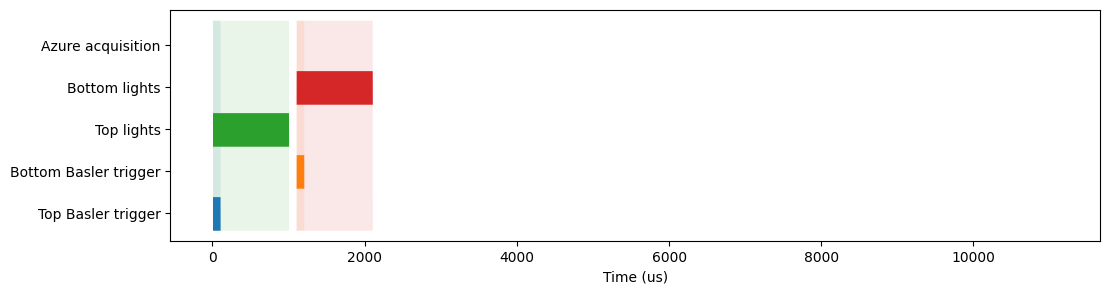

In [27]:
reset_loggers()

save_loc, first_video_file_name, full_config = refactor_acquire_video(
    tmp_path,
    full_config,
    recording_duration_s=rec_time_s,
    append_datetime=True,
    overwrite=False,
    logging_level=logging_level
)